<a href="https://colab.research.google.com/github/tillaczel/Machine-learning-workshop/blob/master/Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder MNIST

An autoencoder transforms the input into a reduced representation and converts it back to the input. It can be used for image compression, image denoising, super resolution, night sight, etc. To read more about autoencoders go to (https://blog.keras.io/building-autoencoders-in-keras.html).




## Importing libraries

In [1]:
!pip install tensorflow --upgrade
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)
2.0.0


## Data preparation

### Loading the dataset

Loading the dataset and visualizing the first training sample

Train x shape: (60000, 28, 28)
Train y shape: (60000,)
Test x shape: (10000, 28, 28)
Test y shape: (10000,)


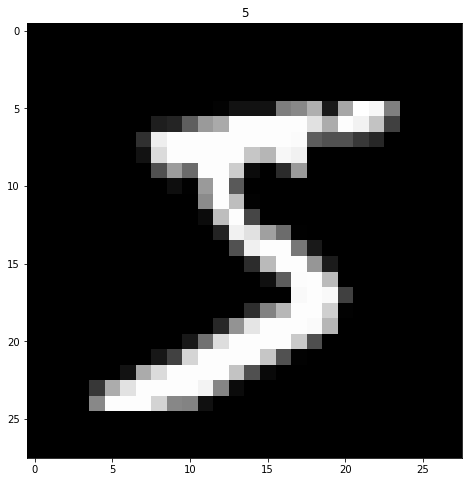

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'Train x shape: {x_train.shape}')
print(f'Train y shape: {y_train.shape}')
print(f'Test x shape: {x_test.shape}')
print(f'Test y shape: {y_test.shape}')

fig = plt.figure(figsize=(8,8))
plt.imshow(x_train[0], cmap='gray')
plt.title(y_train[0])
plt.show()

### Input normalisation and reshaping

Neural networks work the best, if the inputs are normalised, because the weights do not have to take on extreme values. The imput needs to be reshaped, because the Conv2D layer requires a 4 dimensional input.

In [3]:
x_train_norm, x_test_norm,= x_train/255, x_test/255
print(f'Min normalised train x: {np.min(x_train_norm)}')
print(f'Max normalised train x: {np.max(x_train_norm)}')

Min normalised train x: 0.0
Max normalised train x: 1.0


In [4]:
x_train_norm, x_test_norm = x_train_norm[:, :, :, np.newaxis], x_test_norm[:, :, :, np.newaxis]
print(f'New shape of training data: {x_train_norm.shape}')

New shape of training data: (60000, 28, 28, 1)


## Feed forward autoencoder

### Creating the model

First lets define the bottleneck size. This determines the image compression factor. An input image of 28X28 has 784 pixels. A bottleneck of 32 is a 24.5 times compression.

To create the encoder and decoder models, I am using the Model API. First I am defining the encoder, then the decoder. The autoencoder is defined by connecting the two networks. Because the models were defined on the same graph, If we train the autoencoder network, the encoder and decoder will be trained at the same time.

In [5]:
encoding_dim = 32

input_e = layers.Input((28, 28, 1))
e = layers.Flatten()(input_e)
e = layers.Dense(128, activation='relu')(e)
output_e = layers.Dense(encoding_dim, activation='relu')(e)
encoder = Model(input_e, output_e)
encoder.summary()

input_d = layers.Input((encoding_dim))
d = layers.Dense(128, activation='relu')(input_d)
d = layers.Dense(784, activation='sigmoid')(d)
output_d = layers.Reshape((28, 28, 1))(d)
decoder = Model(input_d, output_d)
decoder.summary()

autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.summary()

opt = optimizers.Adam(lr=0.01)
autoencoder.compile(optimizer=opt,
            loss='mse')

history = autoencoder.fit(x_train_norm, x_train_norm, validation_data=(x_test_norm, x_test_norm), epochs=10, batch_size=256)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
Total params: 104,608
Trainable params: 104,608
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
______________________________________

### Visualizing the results

I created 2 rows of 10 images. The first row contains the original images and the second the output of the model. Note, that the reconstructiuon is not perfect, some information was lost durring the compression.

(28, 28, 1)


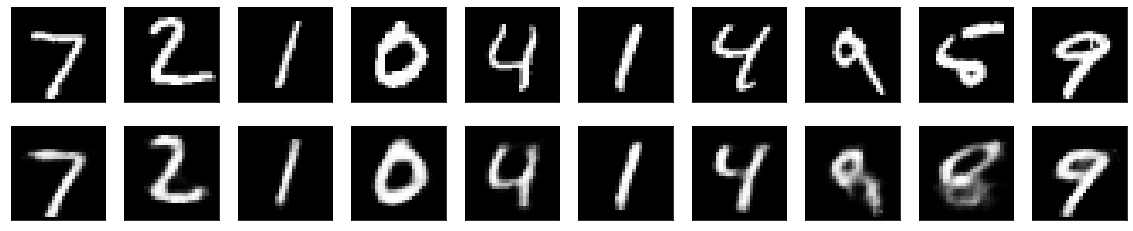

In [6]:
decoded_imgs = autoencoder.predict(x_test_norm)
print(x_test_norm[0].shape)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_norm[i][:, :, 0], cmap='gray')

    plt.subplot(2,10,i+11)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(decoded_imgs[i][:, :, 0], cmap='gray')

plt.show()

## Concolutional autoencoder

### Creating the model

The concolutional autoencoder is similiar to the feed forward autoencoder. The Conv2D and MaxPool layers can reduce the size of the image. In the decoder instead of the Conv2D, the Conv2DTranspose and instead of the MaxPooling2D, the UpSampling2D is used.


In [15]:
encoding_dim = 32

input_e = layers.Input((28, 28, 1))
e = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(input_e)
e = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(e)
e = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(e)
e = layers.MaxPooling2D(pool_size=(2, 2), padding='same')(e)
e = layers.Flatten()(e)
output_e = layers.Dense(encoding_dim, activation='relu')(e)
encoder = Model(input_e, output_e)
encoder.summary()

input_d = layers.Input((encoding_dim))
d = layers.Dense(392, activation='relu')(input_d)
d = layers.Reshape((7, 7, 8))(d)
d = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(d)
d = layers.UpSampling2D((2, 2))(d)
d = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(d)
d = layers.UpSampling2D((2, 2))(d)
output_d = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(d)
decoder = Model(input_d, output_d)
decoder.summary()

autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.summary()

opt = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=opt,
            loss='mse')

history = autoencoder.fit(x_train_norm, x_train_norm, validation_data=(x_test_norm, x_test_norm), epochs=3, batch_size=32)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                125

### Visualizing the results

Same visualization as before.

(28, 28, 1)


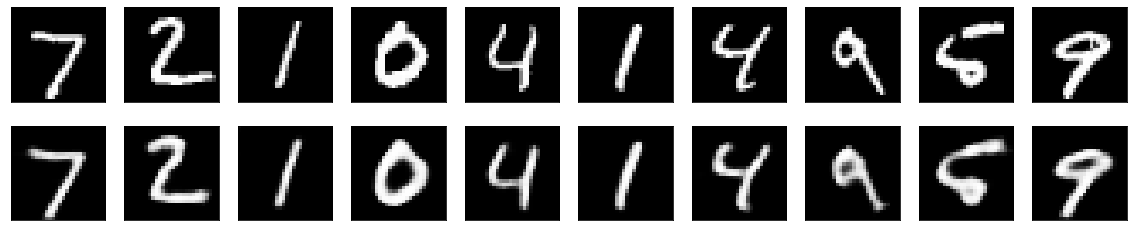

In [16]:
decoded_imgs = autoencoder.predict(x_test_norm)
print(x_test_norm[0].shape)

plt.figure(figsize=(20,4))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_norm[i][:, :, 0], cmap='gray')

    plt.subplot(2,10,i+11)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(decoded_imgs[i][:, :, 0], cmap='gray')

plt.show()